In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '%.5f' % x) #prevent scientific number display
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()

# Import Data

In [2]:
dataset = pd.read_excel('Dataset.xlsx', sheet_name = 'Data Set')
market = pd.read_excel('Dataset.xlsx', sheet_name = 'Market')

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Market ID          720 non-null    int64
 1   Year               720 non-null    int64
 2   Month              720 non-null    int64
 3   Rent               720 non-null    int64
 4   Fees               720 non-null    int64
 5   Starting Units     720 non-null    int64
 6   New Units          720 non-null    int64
 7   Lost Units         720 non-null    int64
 8   Total Nights Sold  720 non-null    int64
dtypes: int64(9)
memory usage: 50.8 KB


In [4]:
market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Market    20 non-null     object
 1   MarketId  20 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 448.0+ bytes


# Data Processing

In [5]:
# join the datasets (dataset & market)

col_drop = ['MarketId','Market ID']

org_data_set = dataset.merge(market, how = 'left', left_on = 'Market ID',
            right_on = 'MarketId' ).drop(columns = col_drop )

org_data_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 720 entries, 0 to 719
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Year               720 non-null    int64 
 1   Month              720 non-null    int64 
 2   Rent               720 non-null    int64 
 3   Fees               720 non-null    int64 
 4   Starting Units     720 non-null    int64 
 5   New Units          720 non-null    int64 
 6   Lost Units         720 non-null    int64 
 7   Total Nights Sold  720 non-null    int64 
 8   Market             720 non-null    object
dtypes: int64(8), object(1)
memory usage: 56.2+ KB


### Aggregate Transformantion

In [6]:
# Create date index, order columns and groups by date eliminating Market

from pandas.tseries.offsets import MonthEnd

org_data_set['YearMonth'] = org_data_set['Year'].astype(str)+org_data_set['Month'].astype(str)

org_data_set['Date']= pd.to_datetime(org_data_set['YearMonth'], format="%Y%m") + MonthEnd(1)

col_drop1 = ['YearMonth']
#col_drop1 = ['Year','Month', 'YearMonth'] 

column_order = ['Month','Rent','Fees','Total Nights Sold',
               'Starting Units','New Units','Lost Units']

org_data_set = org_data_set.drop(columns = 'Month').groupby('Date').sum()

org_data_set['Month'] = pd.DatetimeIndex(org_data_set.index).month
org_data_set = org_data_set.reindex(columns = column_order)#.set_index(['Date']).sort_index()

org_data_set.head()

,Month,Rent,Fees,Total Nights Sold,Starting Units,New Units,Lost Units
Date,,,,,,,
2019-01-31,1,2819632,768131,21058,1965,77,66
2019-02-28,2,3293731,802415,23777,1994,68,49
2019-03-31,3,5903504,1675303,33748,2020,411,41
2019-04-30,4,6061874,1909305,33399,2389,133,43
2019-05-31,5,6938249,2283756,37130,2463,77,55


<AxesSubplot:xlabel='Date'>

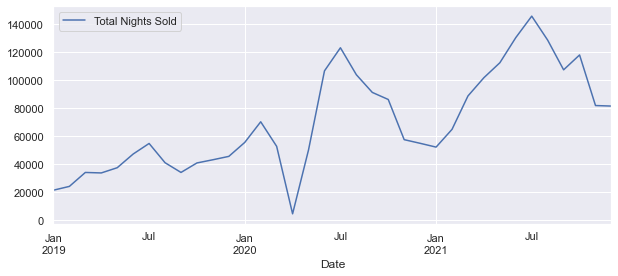

In [7]:
#Nights graph to observe data
org_data_set['Total Nights Sold'].plot.line( figsize = (10,4), legend = True )

In [8]:
# Set up data to calculate outlier months in 2020 (COVID) at Market level.
pd.options.mode.chained_assignment = None  # default='warn'

#Update as needed:
#----------------------------------------------------------------|
time_range_comparable = slice('2021-02-28','2021-06-30')# needs an additional month
time_covid_start = '2020-02-29'
time_covid_period = slice('2020-02-29','2020-05-31')
col_drop2 = ['Starting Units','New Units','Lost Units']
col_drop3 = ['Rent','Fees','Total Nights Sold']

#Gets the data needed for the calculation comparable and covid period
comparable_period = org_data_set.loc[(time_range_comparable),:].reset_index().drop(columns = col_drop2 )
time_covid_start = org_data_set.loc[(time_covid_start),:]
unchanged_cols_covid_2020 = org_data_set.loc[(time_covid_period),:].reset_index().drop(columns = col_drop3 )
#----------------------------------------------------------------|

#Update as needed:
#---------------------------------------------------------------|
col1 = 'Rent'
col2 = 'Fees'
col3 = 'Total Nights Sold'
delta_col1_name = 'Rent_delta'
delta_col2_name = 'Fees_delta'
delta_col3_name = 'Total Nights Sold_delta'

#Creates the % change from month to month
comparable_period[delta_col1_name] = comparable_period[col1].pct_change(periods = 1)
comparable_period[delta_col2_name] = comparable_period[col2].pct_change(periods = 1)
comparable_period[delta_col3_name] = comparable_period[col3].pct_change(periods = 1)
comparable_period = comparable_period.drop(columns = col_drop3).dropna()
#---------------------------------------------------------------|

#Creates date column for covid period
covid_dates = unchanged_cols_covid_2020.iloc[:,0]

In [97]:
# Recalculation of  outlier columns in months of 2020 (COVID)
#----------------------------------------------------------------|
#Update as needed:
col = 'Total Nights Sold'
col_delta = col+'_delta'

#adds values to be transforms into lists
attribute = list()
attribute = [time_covid_start[col]]
pct_change = list()
pct_change = [x for x in comparable_period[col_delta]]
covid_dates = [x for x in covid_dates]
covid_outlier_ouput = dict()
    
for i in range(len(pct_change)):
    if i == 0: attribute.append(attribute[0]*(1+pct_change[0]))  
    else: attribute.append(attribute[i]*(1+pct_change[i]))
print('Recalculated'+' '+col+':',attribute[1:])
        
for i in range(len(attribute)-1):
    covid_outlier_ouput[covid_dates[i]] = attribute[i+1]
#----------------------------------------------------------------|
    
#----------------------------------------------------------------|
#Update as needed:
column_order1 = ['Month','Rent','Fees','Total Nights Sold',
               'Starting Units','New Units','Lost Units']

unchanged_cols_covid_2020[col] = unchanged_cols_covid_2020.Date.map(covid_outlier_ouput)

updated_cols_covid_2020 = unchanged_cols_covid_2020.set_index(['Date'],
                                drop = True).reindex(columns = column_order1)
updated_cols_covid_2020
#----------------------------------------------------------------|

Recalculated Total Nights Sold: [95896.15230957432, 110065.53608758264, 121643.39560847952, 141139.98211492898]


,Month,Rent,Fees,Total Nights Sold,Starting Units,New Units,Lost Units
Date,,,,,,,
2020-02-29,2,19164643.99898,5842868.20481,95896.15231,5887,360,111
2020-03-31,3,20455433.33064,6813731.06730,110065.53609,6145,98,99
2020-04-30,4,24791077.62514,7827033.69850,121643.39561,6141,34,133
2020-05-31,5,42275045.62593,10224111.34004,141139.98211,6013,59,122


In [98]:
#Get data by columns without outlier and appends updated outlier data.

Agg_df = org_data_set.drop( index = covid_dates)
Agg_df = Agg_df.append(updated_cols_covid_2020).sort_index()

<AxesSubplot:xlabel='Date'>

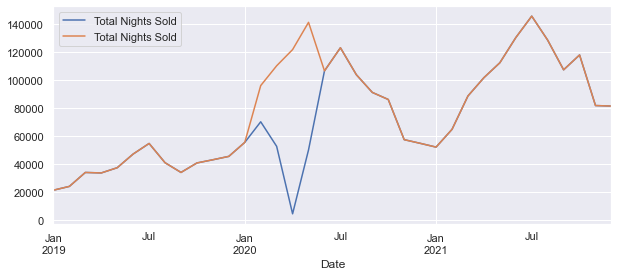

In [11]:
org_data_set['Total Nights Sold'].plot.line( figsize = (10,4), legend = True )
Agg_df['Total Nights Sold'].plot.line( figsize = (10,4), legend = True )

In [12]:
#caluculate inventory
Agg_df['Inventory'] = (Agg_df['Starting Units']+Agg_df['New Units'])-Agg_df['Lost Units']

#adds rate col
Agg_df['rate'] = Agg_df['Rent']/Agg_df['Total Nights Sold']

#adds fee per unit
Agg_df['fee_unit'] = Agg_df['Fees']/Agg_df['Total Nights Sold']

#adds period col
Agg_df['Period'] = np.arange(len(Agg_df))

#Dummy Variables
Agg_df = pd.get_dummies(Agg_df, columns = ['Month'], drop_first = True)

In [13]:
Agg_df.head()

,Rent,Fees,Total Nights Sold,Starting Units,New Units,Lost Units,Inventory,rate,fee_unit,Period,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-31,2819632.00000,768131.00000,21058.00000,1965,77,66,1976,133.89838,36.47692,0,...,0,0,0,0,0,0,0,0,0,0
2019-02-28,3293731.00000,802415.00000,23777.00000,1994,68,49,2013,138.52593,33.74753,1,...,0,0,0,0,0,0,0,0,0,0
2019-03-31,5903504.00000,1675303.00000,33748.00000,2020,411,41,2390,174.92900,49.64155,2,...,1,0,0,0,0,0,0,0,0,0
2019-04-30,6061874.00000,1909305.00000,33399.00000,2389,133,43,2479,181.49867,57.16653,3,...,0,1,0,0,0,0,0,0,0,0
2019-05-31,6938249.00000,2283756.00000,37130.00000,2463,77,55,2485,186.86370,61.50703,4,...,0,0,1,0,0,0,0,0,0,0


<AxesSubplot:>

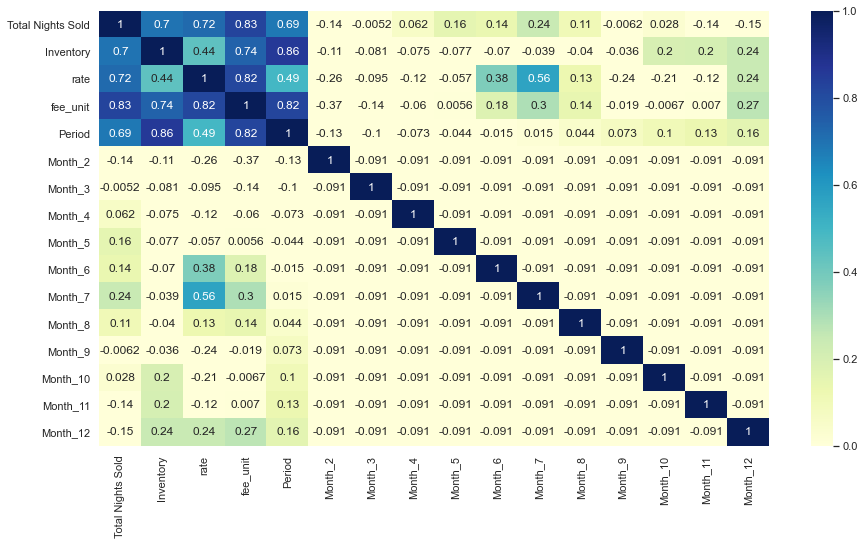

In [14]:
#Correlation Analysis
corr_col=['Total Nights Sold','Inventory','rate', 'fee_unit','Period','Month_2',
          'Month_3','Month_4','Month_5','Month_6','Month_7','Month_8','Month_9','Month_10','Month_11','Month_12']

sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(Agg_df[corr_col].corr(),annot = True,vmin=0, vmax=1, cmap="YlGnBu")

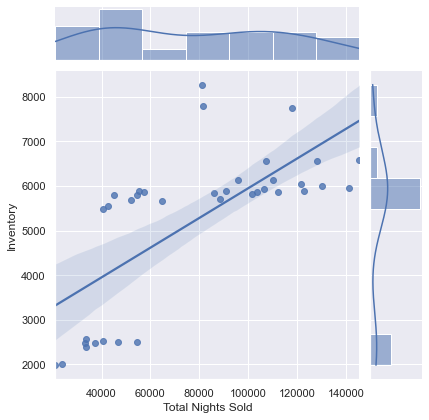

In [15]:
sns.jointplot( x ='Total Nights Sold',y ='Inventory', data = Agg_df, kind = 'reg')

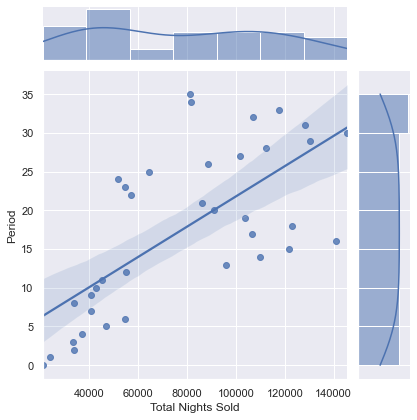

In [16]:
sns.jointplot( x ='Total Nights Sold',y ='Period', data = Agg_df, kind = 'reg')

# Linear Regression

In [17]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn import metrics

In [18]:
# Dependent variabel
y = Agg_df['Total Nights Sold']

# Independent variables
x = Agg_df[['Inventory','Month_2','Month_3','Month_4','Month_5','Month_6',
        'Month_7','Month_8','Month_9','Month_10','Month_11','Month_12']] 

In [19]:
# Train test split
#size = int(len(x)*0.8)
size = 24
x_train,y_train = x.iloc[:size],y.iloc[:size]
x_test, y_test = x.iloc[size:],y.iloc[size:]

### Train

In [20]:
#Regression model
lm = LinearRegression()
lm.fit(x_train,y_train)

#Coefficients
print('Itercept: %.0f' % lm.intercept_)
print('Coefficients:',lm.coef_)

#Run with differrent lib to get summary
x_ctrain = sm.add_constant(x_train)
est = sm.OLS(y_train, x_ctrain)
est2 = est.fit()
print(est2.summary())

Itercept: -37565
Coefficients: [ 1.92368095e+01  1.90212780e+04  2.73883841e+04  3.31278531e+04
  4.55688292e+04  3.31620486e+04  4.55790479e+04  2.89949559e+04
  1.86932989e+04 -8.30521972e+03 -2.21547976e+04 -2.41137681e+04]
                            OLS Regression Results                            
Dep. Variable:      Total Nights Sold   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     9.376
Date:                Mon, 07 Feb 2022   Prob (F-statistic):           0.000390
Time:                        09:24:03   Log-Likelihood:                -256.29
No. Observations:                  24   AIC:                             538.6
Df Residuals:                      11   BIC:                             553.9
Df Model:                          12                                         
Covariance Type:            nonrobust                         

In [21]:
#Predict train
train_predictions = lm.predict(x_train)

In [22]:
#Train performance
print('mape: %.2f' % metrics.mean_absolute_percentage_error(y_train,train_predictions))
print('rmse: %.0f' % np.sqrt(metrics.mean_squared_error(y_train,train_predictions)))
#print('Coefficient of determination: %.2f' % metrics.r2_score(y_train,train_predictions))
print('mean: %.0f' % y_train.mean())
print('Std Dev: %.0f' % np.sqrt(y_train.var()))

mape: 0.17
rmse: 10505
mean: 66642
Std Dev: 35958


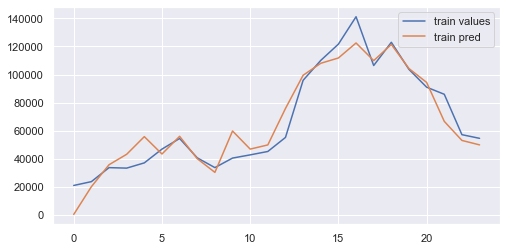

In [23]:
#Train vs train y values
plt.figure(figsize=(8,4))
x_points = list(range(len(y_train)))
plt.plot(x_points, y_train, label = 'train values' )
plt.plot(x_points, train_predictions, label = 'train pred')
plt.legend()

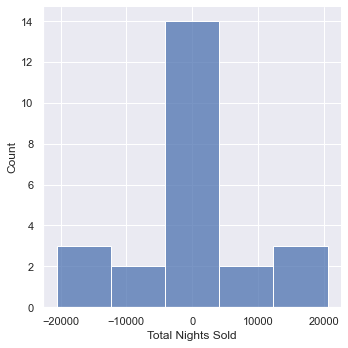

In [24]:
#Train Residuals
sns.displot(y_train-train_predictions, bins =5 )

### Test

In [25]:
#Predict test
predictions = lm.predict(x_test)

In [26]:
#Test performance
print('mape: %.2f' % metrics.mean_absolute_percentage_error(y_test,predictions))
print('rmse: %.0f' % np.sqrt(metrics.mean_squared_error(y_test,predictions)))
print('Coefficient of determination: %.2f' % metrics.r2_score(y_test,predictions))
print('mean: %.0f' % y_test.mean())
print('Std Dev: %.0f' % np.sqrt(y_test.var()))

mape: 0.15
rmse: 14277
Coefficient of determination: 0.72
mean: 100896
Std Dev: 28125


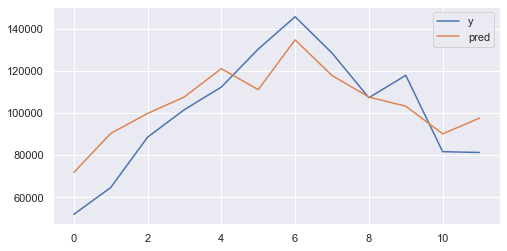

In [27]:
#test prediction vs true values
plt.figure(figsize=(8,4))
x_points = list(range(len(y_test)))
plt.plot(x_points, y_test, label = 'y' )
plt.plot(x_points, predictions, label = 'pred')
plt.legend()

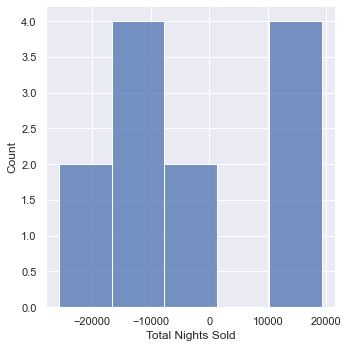

In [28]:
#Residuals
sns.displot(y_test-predictions, bins =5 )

### Forecast

In [29]:
#Actual fcasts
lm.predict([[58843,0,0,0,0,0,1,0,0,0,0,0]])

array([1139965.54776657])

### Natural log Transformation

In [30]:
#transform x & y using log
Agg_df['Inventory_log'] =  np.log(Agg_df['Inventory']+1)
Agg_df['Total Nights Sold_log'] =  np.log(Agg_df['Total Nights Sold']+1)

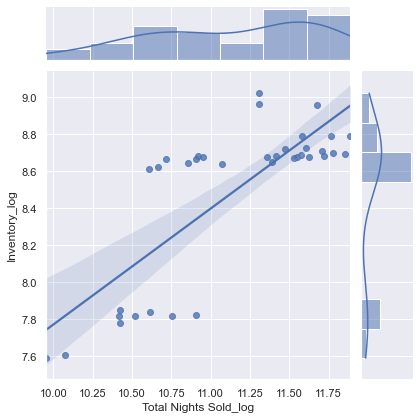

In [31]:
#graph transformation
sns.jointplot( x ='Total Nights Sold_log',y ='Inventory_log', data = Agg_df, kind = 'reg')

<AxesSubplot:>

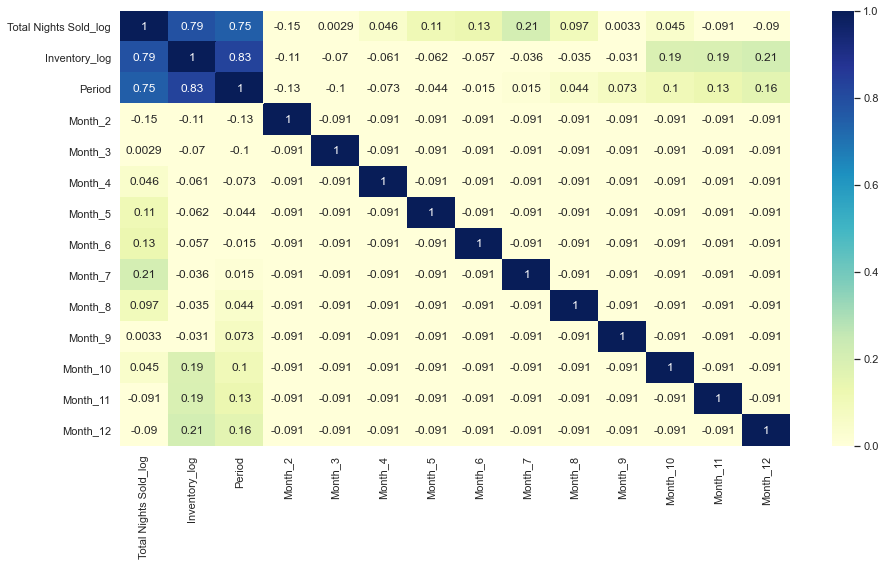

In [32]:
#Correlation Analysis
corr_col=['Total Nights Sold_log','Inventory_log','Period','Month_2',
          'Month_3','Month_4','Month_5','Month_6','Month_7','Month_8','Month_9','Month_10','Month_11','Month_12']

sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(Agg_df[corr_col].corr(),annot = True,vmin=0, vmax=1, cmap="YlGnBu")

In [33]:
# Dependent variabel
y_l = Agg_df['Total Nights Sold_log']

# Independent variables
x_l = Agg_df[['Inventory_log','Month_2','Month_3','Month_4','Month_5','Month_6',
        'Month_7','Month_8','Month_9','Month_10','Month_11','Month_12']] 

In [34]:
# Train test split
#size = int(len(x)*0.8)
size = 24
x_train_l,y_train_l = x_l.iloc[:size],y_l.iloc[:size]
x_test_l, y_test_l = x_l.iloc[size:],y_l.iloc[size:]

### Train

In [35]:
#Regression model
lm = LinearRegression()
lm.fit(x_train_l,y_train_l)
print('Intercept:',lm.intercept_)
print('Coef:',lm.coef_)

#Run with differrent lib to get summary
x_ctrain_l = sm.add_constant(x_train_l)
est = sm.OLS(y_train_l, x_ctrain_l)
est2 = est.fit()
print(est2.summary())

Intercept: 0.8989250694488522
Coef: [ 1.17240116  0.30221125  0.44486147  0.47806063  0.61291398  0.58912379
  0.7385952   0.50234542  0.3346805  -0.04616858 -0.2290871  -0.24514462]
                              OLS Regression Results                             
Dep. Variable:     Total Nights Sold_log   R-squared:                       0.936
Model:                               OLS   Adj. R-squared:                  0.866
Method:                    Least Squares   F-statistic:                     13.38
Date:                   Mon, 07 Feb 2022   Prob (F-statistic):           7.17e-05
Time:                           09:24:07   Log-Likelihood:                 13.687
No. Observations:                     24   AIC:                            -1.373
Df Residuals:                         11   BIC:                             13.94
Df Model:                             12                                         
Covariance Type:               nonrobust                                       

In [36]:
#forecast train
train_predictions_l = lm.predict(x_train_l)

In [37]:
#Reverse scale
train_predictions_l = np.exp(train_predictions_l)-1
y_train_l = np.exp(y_train_l)-1

In [38]:
#Train performance
print('mape: %.2f' % metrics.mean_absolute_percentage_error(y_train_l,train_predictions_l))
print('rmse: %.0f' % np.sqrt(metrics.mean_squared_error(y_train_l,train_predictions_l)))
#print('Coefficient of determination: %.2f' % metrics.r2_score(y_train,train_predictions))
print('mean: %.0f' % y_train_l.mean())
print('Std Dev: %.0f' % np.sqrt(y_train_l.var()))

mape: 0.11
rmse: 9430
mean: 66642
Std Dev: 35958


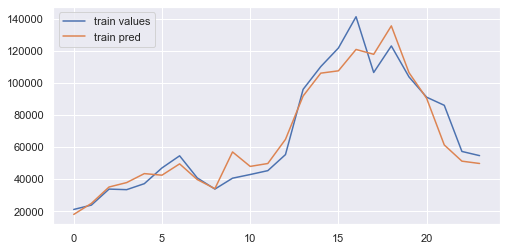

In [39]:
#Train vs train y values
plt.figure(figsize=(8,4))
x_points = list(range(len(y_train_l)))
plt.plot(x_points, y_train_l, label = 'train values' )
plt.plot(x_points, train_predictions_l, label = 'train pred')
plt.legend()

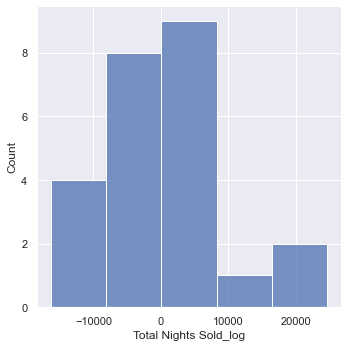

In [40]:
#Train Residuals
sns.displot(y_train_l-train_predictions_l, bins =5 )

### Test

In [41]:
#predict  test
test_predictions_l = lm.predict(x_test_l)

In [42]:
#Reverse scale
test_predictions_l = np.exp(test_predictions_l)-1
y_test_l = np.exp(y_test_l)-1

In [43]:
#Test performance
print('mape: %.2f' % metrics.mean_absolute_percentage_error(y_test_l,test_predictions_l))
print('rmse: %.0f' % np.sqrt(metrics.mean_squared_error(y_test_l,test_predictions_l)))
print('Coefficient of determination: %.2f' % metrics.r2_score(y_test_l,test_predictions_l))
print('mean: %.0f' % y_test_l.mean())
print('Std Dev: %.0f' % np.sqrt(y_test_l.var()))

mape: 0.11
rmse: 13089
Coefficient of determination: 0.76
mean: 100896
Std Dev: 28125


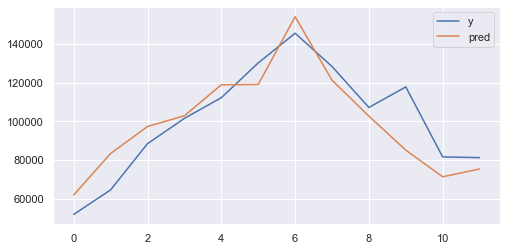

In [44]:
#Forecast vs true values
plt.figure(figsize=(8,4))
x_points = list(range(len(y_test_l)))
plt.plot(x_points, y_test_l, label = 'y' )
plt.plot(x_points, test_predictions_l, label = 'pred')
plt.legend()

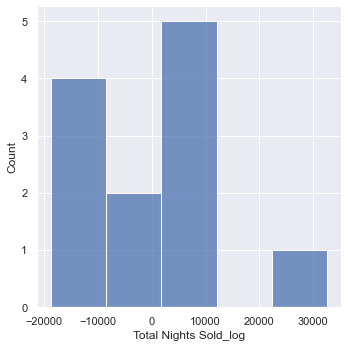

In [45]:
#Residuals test
sns.displot(y_test_l-test_predictions_l, bins =5 )

# Ridge Regression (L2 Regularization)

In [46]:
from sklearn.linear_model import Ridge

In [47]:
#transform x & y using log
Agg_df['Inventory_log'] =  np.log(Agg_df['Inventory']+1)
Agg_df['Total Nights Sold_log'] =  np.log(Agg_df['Total Nights Sold']+1)

In [48]:
# Dependent variabel
y_l = Agg_df['Total Nights Sold_log']

# Independent variables
x_l = Agg_df[['Inventory_log','Month_2','Month_3','Month_4','Month_5','Month_6',
        'Month_7','Month_8','Month_9','Month_10','Month_11','Month_12']] 

In [49]:
# Train test split
#size = int(len(x)*0.8)
size = 24
x_train_l,y_train_l = x_l.iloc[:size],y_l.iloc[:size]
x_test_l, y_test_l = x_l.iloc[size:],y_l.iloc[size:]

### Train

In [50]:
l2_r = Ridge(alpha = 1.5)
l2_r.fit(x_train_l, y_train_l)

Ridge(alpha=1.5)

In [51]:
#predict train
train_predictions_l2_r = l2_r.predict(x_train_l)

In [52]:
#Reverse scale
train_predictions_l2_r = np.exp(train_predictions_l2_r)-1
y_train_l = np.exp(y_train_l)-1

In [53]:
#Train performance
print('mape: %.2f' % metrics.mean_absolute_percentage_error(y_train_l,train_predictions_l2_r))
print('rmse: %.0f' % np.sqrt(metrics.mean_squared_error(y_train_l,train_predictions_l2_r)))
print('Coefficient of determination: %.2f' % metrics.r2_score(y_train,train_predictions_l2_r))
print('mean: %.0f' % y_train_l.mean())
print('Std Dev: %.0f' % np.sqrt(y_train_l.var()))

mape: 0.23
rmse: 19403
Coefficient of determination: 0.70
mean: 66642
Std Dev: 35958


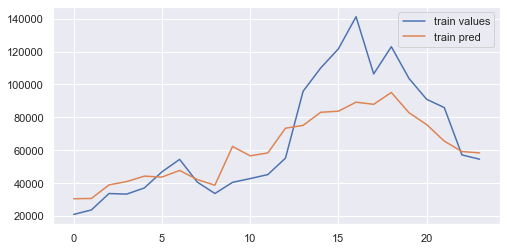

In [54]:
#Train vs train y values
plt.figure(figsize=(8,4))
x_points = list(range(len(y_train_l)))
plt.plot(x_points, y_train_l, label = 'train values' )
plt.plot(x_points, train_predictions_l2_r, label = 'train pred')
plt.legend()

### Test

In [55]:
#predict  test
test_predictions_l2_r = l2_r.predict(x_test_l)

In [56]:
#Reverse scale
test_predictions_l2_r = np.exp(test_predictions_l2_r)-1
y_test_l = np.exp(y_test_l)-1

In [57]:
#Test performance
print('mape: %.2f' % metrics.mean_absolute_percentage_error(y_test_l,test_predictions_l2_r))
print('rmse: %.0f' % np.sqrt(metrics.mean_squared_error(y_test_l,test_predictions_l2_r)))
print('Coefficient of determination: %.2f' % metrics.r2_score(y_test,test_predictions_l2_r))
print('mean: %.0f' % y_test_l.mean())
print('Std Dev: %.0f' % np.sqrt(y_test_l.var()))

mape: 0.21
rmse: 26337
Coefficient of determination: 0.04
mean: 100896
Std Dev: 28125


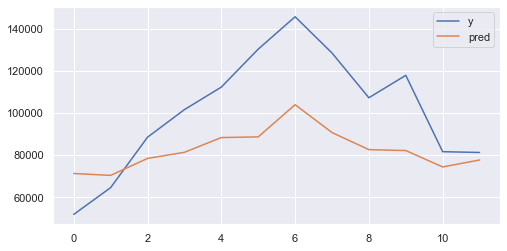

In [58]:
#test prediction vs true values
plt.figure(figsize=(8,4))
x_points = list(range(len(y_test)))
plt.plot(x_points, y_test, label = 'y' )
plt.plot(x_points, test_predictions_l2_r, label = 'pred')
plt.legend()

# Lasso Regression (L1 Regularization)

In [59]:
from sklearn.linear_model import Lasso

In [60]:
#transform x & y using log
Agg_df['Inventory_log'] =  np.log(Agg_df['Inventory']+1)
Agg_df['Total Nights Sold_log'] =  np.log(Agg_df['Total Nights Sold']+1)

In [61]:
# Dependent variabel
y_l = Agg_df['Total Nights Sold_log']

# Independent variables
x_l = Agg_df[['Inventory_log','Month_2','Month_3','Month_4','Month_5','Month_6',
        'Month_7','Month_8','Month_9','Month_10','Month_11','Month_12']] 

In [62]:
# Train test split
#size = int(len(x)*0.8)
size = 24
x_train_l,y_train_l = x_l.iloc[:size],y_l.iloc[:size]
x_test_l, y_test_l = x_l.iloc[size:],y_l.iloc[size:]

### Train

In [63]:
l1_r = Lasso(alpha = 0.01)
l1_r.fit(x_train_l, y_train_l)

Lasso(alpha=0.01)

In [64]:
#predict train
train_predictions_l1_r = l1_r.predict(x_train_l)

In [65]:
#Reverse scale
train_predictions_l1_r = np.exp(train_predictions_l1_r)-1
y_train_l = np.exp(y_train_l)-1

In [66]:
#Train performance
print('mape: %.2f' % metrics.mean_absolute_percentage_error(y_train_l,train_predictions_l1_r))
print('rmse: %.0f' % np.sqrt(metrics.mean_squared_error(y_train_l,train_predictions_l1_r)))
print('Coefficient of determination: %.2f' % metrics.r2_score(y_train,train_predictions_l1_r))
print('mean: %.0f' % y_train_l.mean())
print('Std Dev: %.0f' % np.sqrt(y_train_l.var()))

mape: 0.17
rmse: 15199
Coefficient of determination: 0.81
mean: 66642
Std Dev: 35958


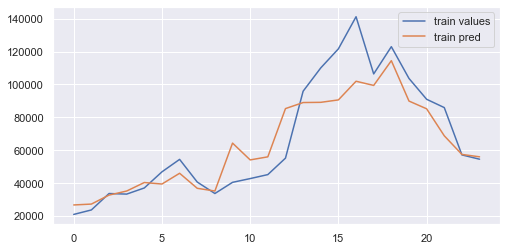

In [67]:
#Train vs train y values
plt.figure(figsize=(8,4))
x_points = list(range(len(y_train_l)))
plt.plot(x_points, y_train_l, label = 'train values' )
plt.plot(x_points, train_predictions_l1_r, label = 'train pred')
plt.legend()

### Test

In [68]:
#predict  test
test_predictions_l1_r = l1_r.predict(x_test_l)

In [69]:
#Reverse scale
test_predictions_l1_r = np.exp(test_predictions_l1_r)-1
y_test_l = np.exp(y_test_l)-1

In [70]:
#Test performance
print('mape: %.2f' % metrics.mean_absolute_percentage_error(y_test_l,test_predictions_l1_r))
print('rmse: %.0f' % np.sqrt(metrics.mean_squared_error(y_test_l,test_predictions_l1_r)))
print('Coefficient of determination: %.2f' % metrics.r2_score(y_test,test_predictions_l1_r))
print('mean: %.0f' % y_test_l.mean())
print('Std Dev: %.0f' % np.sqrt(y_test_l.var()))

mape: 0.17
rmse: 18858
Coefficient of determination: 0.51
mean: 100896
Std Dev: 28125


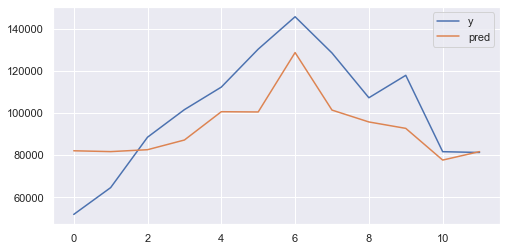

In [71]:
#test prediction vs true values
plt.figure(figsize=(8,4))
x_points = list(range(len(y_test)))
plt.plot(x_points, y_test, label = 'y' )
plt.plot(x_points, test_predictions_l1_r, label = 'pred')
plt.legend()

# Elastic Net

In [72]:
from sklearn.linear_model import ElasticNet

In [73]:
#transform x & y using log
Agg_df['Inventory_log'] =  np.log(Agg_df['Inventory']+1)
Agg_df['Total Nights Sold_log'] =  np.log(Agg_df['Total Nights Sold']+1)

In [74]:
# Dependent variabel
y_l = Agg_df['Total Nights Sold_log']

# Independent variables
x_l = Agg_df[['Inventory_log','Month_2','Month_3','Month_4','Month_5','Month_6',
        'Month_7','Month_8','Month_9','Month_10','Month_11','Month_12']]

In [75]:
# Train test split
#size = int(len(x)*0.8)
size = 24
x_train_l,y_train_l = x_l.iloc[:size],y_l.iloc[:size]
x_test_l, y_test_l = x_l.iloc[size:],y_l.iloc[size:]

### Train

In [76]:
en_r = ElasticNet(alpha = 0.007,l1_ratio=0.5)
en_r.fit(x_train_l, y_train_l)

ElasticNet(alpha=0.007)

In [77]:
#predict train
train_predictions_en_r = en_r.predict(x_train_l)

In [78]:
#Reverse scale
train_predictions_en_r = np.exp(train_predictions_en_r)-1
y_train_l = np.exp(y_train_l)-1

In [79]:
#Train performance
print('mape: %.2f' % metrics.mean_absolute_percentage_error(y_train_l,train_predictions_en_r))
print('rmse: %.0f' % np.sqrt(metrics.mean_squared_error(y_train_l,train_predictions_en_r)))
print('Coefficient of determination: %.2f' % metrics.r2_score(y_train,train_predictions_en_r))
print('mean: %.0f' % y_train_l.mean())
print('Std Dev: %.0f' % np.sqrt(y_train_l.var()))

mape: 0.13
rmse: 12012
Coefficient of determination: 0.88
mean: 66642
Std Dev: 35958


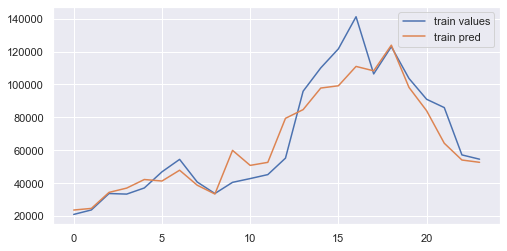

In [80]:
#Train vs train y values
plt.figure(figsize=(8,4))
x_points = list(range(len(y_train_l)))
plt.plot(x_points, y_train_l, label = 'train values' )
plt.plot(x_points, train_predictions_en_r, label = 'train pred')
plt.legend()

### Test

In [81]:
#predict  test
test_predictions_en_r = en_r.predict(x_test_l)

In [82]:
#Reverse scale
test_predictions_en_r = np.exp(test_predictions_en_r)-1
y_test_l = np.exp(y_test_l)-1

In [83]:
#Test performance
print('mape: %.2f' % metrics.mean_absolute_percentage_error(y_test_l,test_predictions_en_r))
print('rmse: %.0f' % np.sqrt(metrics.mean_squared_error(y_test_l,test_predictions_en_r)))
print('Coefficient of determination: %.2f' % metrics.r2_score(y_test,test_predictions_en_r))
print('mean: %.0f' % y_test_l.mean())
print('Std Dev: %.0f' % np.sqrt(y_test_l.var()))

mape: 0.13
rmse: 14977
Coefficient of determination: 0.69
mean: 100896
Std Dev: 28125


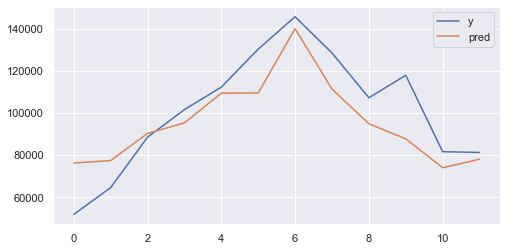

In [84]:
#test prediction vs true values
plt.figure(figsize=(8,4))
x_points = list(range(len(y_test)))
plt.plot(x_points, y_test, label = 'y' )
plt.plot(x_points, test_predictions_en_r, label = 'pred')
plt.legend()

# Polynomial Regression

In [85]:
from sklearn.preprocessing import PolynomialFeatures

In [86]:
# Dependent variabel
y = Agg_df['Total Nights Sold']

# Independent variables
x = Agg_df[['Inventory','Month_2','Month_3','Month_4','Month_5','Month_6',
        'Month_7','Month_8','Month_9','Month_10','Month_11','Month_12']]

In [87]:
# Train test split
#size = int(len(x)*0.8)
size = 24
x_train,y_train = x.iloc[:size],y.iloc[:size]
x_test, y_test = x.iloc[size:],y.iloc[size:]

### Train

In [88]:
#Transform features into polynomial features

polynomial = PolynomialFeatures(degree = 2 )

x_train_p = polynomial.fit_transform(x_train)
x_test_p = polynomial.fit_transform(x_test)

In [103]:
lm_model = LinearRegression()

lm_model.fit(x_train_p,y_train)

train_pred = lm_model.predict(x_train_p)

In [90]:
#Train performance
print('mape: %.2f' % metrics.mean_absolute_percentage_error(y_train,train_pred))
print('rmse: %.0f' % np.sqrt(metrics.mean_squared_error(y_train,train_pred)))
print('Coefficient of determination: %.2f' % metrics.r2_score(y_train,train_pred))
print('mean: %.0f' % y_train.mean())
print('Std Dev: %.0f' % np.sqrt(y_train.var()))

mape: 0.00
rmse: 0
Coefficient of determination: 1.00
mean: 66642
Std Dev: 35958


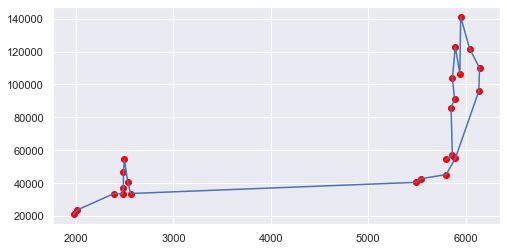

In [91]:
plt.figure(figsize=(8,4))
plt.scatter(x_train.Inventory,y_train, color ='red')
plt.plot(x_train.Inventory, train_pred )

### Test

In [92]:
test_pred = lm_model.predict(x_test_p)

In [93]:
#Test performance
print('mape: %.2f' % metrics.mean_absolute_percentage_error(y_test,test_pred))
print('rmse: %.0f' % np.sqrt(metrics.mean_squared_error(y_test,test_pred)))
print('Coefficient of determination: %.2f' % metrics.r2_score(y_test,test_pred))
print('mean: %.0f' % y_test.mean())
print('Std Dev: %.0f' % np.sqrt(y_test.var()))

mape: 45.34
rmse: 8443895
Coefficient of determination: -98331.62
mean: 100896
Std Dev: 28125


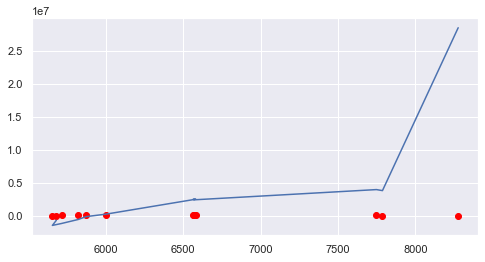

In [94]:
plt.figure(figsize=(8,4))
plt.scatter(x_test.Inventory,y_test, color ='red')
plt.plot(x_test.Inventory, test_pred)